In [41]:
"""
This file is used for initial filtering and understanding of data.
At different points in the filtering process, files are saved.

File names for filtered data:

For data filtered to specific day range:
/filtered/[day start]_[day end]_....

/filtered/[date range]/[areas]_[filtering details]

areas:
e.g. county_middlesex_norfolk_suffolk (only contains data in these counties)
e.g. cities_cambridge_brookline_boston_somerville (only contains data in these cities)

filtering_details
e.g. 10days_10nights (only contains data for users with at least 10 nights & 10 days of data)

end up with something like...
e.g. /filtered/20180501_20180514/county_middlesex_norfolk_suffolk_10days_10nights.csv

"""
from datetime import datetime, timedelta
from dateutil import parser

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from shapely.geometry import Point, Polygon

MSA = "14460"
YEARMONTH = "201805"


DATA_PATH = "./data/mount/{yearmonth}/".format(yearmonth=YEARMONTH)

FILTERED_DATA_PATH = "{data_path}filtered/".format(data_path=DATA_PATH)

input_filename = "{msa}_{yearmonth}.csv".format(msa=MSA, yearmonth=YEARMONTH)
input_filepath = DATA_PATH + input_filename
print('using input filepath: ', input_filepath)
print('output filtered data filepath: ', FILTERED_DATA_PATH)

using input filepath:  ./data/mount/201805/14460_201805.csv
output filtered data filepath:  ./data/mount/201805/filtered/


In [42]:
# Column names defined as variables

DEVICE_ID = 'device ID'
DWELLTIME = 'DwellTime'
TIMESTAMP = 'timestamp'

# temp added column
TIMESTAMP_DAY = 'timestamp day'

Handling timestamps:

From provided data documentation:
Timestamp of the data point in ISO-8601. Times are expressed in local time, together with a time zone offset in hours and minutes. A time zone offset of "+hh:mm" indicates that the date/time uses a local time zone which is "hh" hours and "mm" minutes ahead of UTC. A time zone offset of "-hh:mm" indicates that the date/time uses a local time zone which is "hh" hours and "mm" minutes behind UTC.

We convert the timestamp to a datetime __without__ the built in pandas to_datetime function in, because we want to keep the relavent timezone information and this function shifts the hour to reflect only the UTC datetime.

e.g. `df[column] = df[column].apply(lambda t: parser.parse(str(t)))`

In [43]:
def timestamp_to_datetime(df, column=TIMESTAMP):
    df[column] = df[column].apply(lambda t: parser.parse(str(t)))
    return df

## Filter by days

Filter the data to only include the days of interest.
For us, this is a 5 day workweek (Monday - Friday).

Note: There is a 'day' column. This column represents the day that the data was processed.  Not when the dwell occurred.


In [44]:
# The first work week in May (Monday - Friday)
# STARTDAY = 20180507
# ENDDAY = 20180511

# The second full work week in May (Monday - Friday)
STARTDAY = 20180514
ENDDAY = 20180518

startday_str = str(STARTDAY)
endday_str = str(ENDDAY)

In [45]:
def filter_to_days(df, startday_str, endday_str):
    """Returns data frame filtered to rows from the day range."""
    df = timestamp_to_datetime(df, column=TIMESTAMP)
    temp_col = 'withindays'
    df[temp_col] = df[TIMESTAMP].apply(lambda t: startday_str <= t.strftime("%Y%m%d") <= endday_str)
    return df[df[temp_col]].drop(temp_col, axis=1)

In [70]:
"""
The starting file is huge (~1.2 GB), so filtering is done in chunks.

The fitered chunks are appended to a newly written output file.

"""

chunksize = 10**5

filtered_days_seen_set = set() # used for sanity check

days_filtered_output_filepath = "{data_path}{start_day}_{end_day}/{msa}.csv".format(
    data_path=FILTERED_DATA_PATH, start_day=STARTDAY, end_day=ENDDAY, msa=MSA)

print('reading file in chunks of size %s from %s' % (chunksize, input_filepath))
print('writing filtered data to %s' % days_filtered_output_filepath)

chunks_read = 0
input_file_total_lines = 0
filtered_total_lines = 0
# Overwrite existing file (open with 'w').  Write chunks by appending to the file (mode 'a').
with open(days_filtered_output_filepath, 'w') as output_file:
    for df_chunk in pd.read_csv(input_filepath, chunksize=chunksize):
        chunks_read += 1
        lines_read = df_chunk.shape[0]
        # Filter data chunk to the days range
        df_chunk_filtered = filter_to_days(df_chunk, startday_str, endday_str)
        filtered_lines = df_chunk_filtered.shape[0]
        # write the filtered data chunk
        df_chunk_filtered.to_csv(output_file, mode='a', header=(chunks_read == 1), index=False) # mode='a' tells pandas to append; only write the header at top.
        print('chunk %s : lines read: %s, filtered lines: %s' % (chunks_read, lines_read, filtered_lines))
        input_file_total_lines += lines_read
        filtered_total_lines += filtered_lines
        # for sanity checking the days data:
        df_chunk_filtered[TIMESTAMP_DAY] = df_chunk_filtered[TIMESTAMP].apply(lambda t: t.day)
        filtered_days_seen_set.update(list(df_chunk_filtered[TIMESTAMP_DAY].unique()))


print('total input file rows: ', input_file_total_lines)
print('total output file rows:', filtered_total_lines)

# sanity check: expected number of unique days
assert(len(filtered_days_seen_set) == (int(ENDDAY) - int(STARTDAY) + 1))

reading file in chunks of size 100000 from ./data/mount/201805/14460_201805.csv
writing filtered data to ./data/mount/201805/filtered/20180514_20180518/14460.csv
chunk 1 : lines read: 100000, filtered lines: 0
chunk 2 : lines read: 100000, filtered lines: 0
chunk 3 : lines read: 100000, filtered lines: 0
chunk 4 : lines read: 100000, filtered lines: 0
chunk 5 : lines read: 100000, filtered lines: 0
chunk 6 : lines read: 100000, filtered lines: 2792
chunk 7 : lines read: 100000, filtered lines: 3854
chunk 8 : lines read: 100000, filtered lines: 32964
chunk 9 : lines read: 100000, filtered lines: 99396
chunk 10 : lines read: 100000, filtered lines: 99387
chunk 11 : lines read: 100000, filtered lines: 56584
chunk 12 : lines read: 100000, filtered lines: 0
chunk 13 : lines read: 100000, filtered lines: 0
chunk 14 : lines read: 100000, filtered lines: 22744
chunk 15 : lines read: 100000, filtered lines: 38054
chunk 16 : lines read: 100000, filtered lines: 37394
chunk 17 : lines read: 100000

In [71]:
# How much did this filter by vs what we expected?

# Total input data points divided by days of month:
avg_data_pnts_per_day = input_file_total_lines / 31
print('avg datapoints per day (= all datapoints/31 days) =', avg_data_pnts_per_day)
days = (ENDDAY - STARTDAY + 1)
print('filtered days =', days)
expected_datapoints = avg_data_pnts_per_day*days
print('expected datapoints = avg datapoints per day * days =', expected_datapoints)
print('true datapoints count for the %s days =' % days, filtered_total_lines)

avg datapoints per day (= all datapoints/31 days) = 280027.70967741933
filtered days = 5
expected datapoints = avg datapoints per day * days = 1400138.5483870967
true datapoints count for the 5 days = 1389373


## Filter by geographic region

Filter to geographic region of interest.
e.g. counties: Middlesex, Norfolk, Suffolk

- Data is filtered to points that occur within the geographic region.
- Geographic region is defined by shapefiles.
-  The shapefiles are divided by county.

./shapefiles/ma/county_middlesex_norfolk_suffolk.shp


,STATEFP10,COUNTYFP10,COUNTYNS10,GEOID10,NAME10,NAMELSAD10,LSAD10,CLASSFP10,MTFCC10,CSAFP10,CBSAFP10,METDIVFP10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
0,25,021,00606937,25021,Norfolk,Norfolk County,06,H1,G4020,148,14460,14484,A,1025908386,124944841,+42.1697025,-071.1798747,(POLYGON ((-71.1575566213608 42.32971866445732...
1,25,025,00606939,25025,Suffolk,Suffolk County,06,H4,G4020,148,14460,14484,N,150618894,160748611,+42.3319600,-071.0201725,POLYGON ((-70.91789254591536 42.38600568279522...
2,25,017,00606935,25017,Middlesex,Middlesex County,06,H4,G4020,148,14460,15764,N,2118135038,75739760,+42.4794770,-071.3965070,"POLYGON ((-71.52218473720555 42.2664526406431,..."


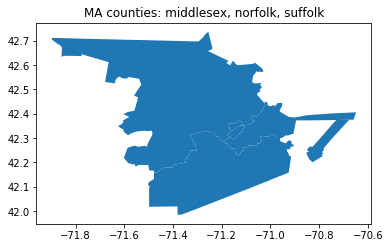

In [72]:

from util import get_shapefile_filename, get_shapefile_filepath

# Load in the shapefile
counties = ['middlesex', 'norfolk', 'suffolk']
counties_shapefile_filepath = get_shapefile_filepath('ma', 'county', counties)
print(counties_shapefile_filepath)

counties_shapefile = gpd.read_file(counties_shapefile_filepath).to_crs(epsg=4326)
counties_shapefile.plot()
plt.title('MA counties: ' + ', '.join(counties))

counties_shapefile.head()

Filter out the points that do not fall within desired county regions.

Along the way, attach the county code 

Write the filtered output to file.

The filtering is done in chunks.

In [73]:
region_filtered_output_filepath = "{data_path}{start_day}_{end_day}/{region}.csv".format(
    data_path=FILTERED_DATA_PATH, start_day=STARTDAY, end_day=ENDDAY,
    region='county_'+'_'.join(sorted(counties)))

In [74]:
COUNTY = 'COUNTY'
COUNTYFP = 'COUNTYFP10'

In [75]:
chunksize = 10**5

filtered_counties_seen_set = set() # used for sanity check

print('filtering data to counties: ' + ', '.join(counties))
print('reading file in chunks of size %s from %s' % (chunksize, days_filtered_output_filepath))
print('writing filtered data to %s' % region_filtered_output_filepath)

def get_county(data_row, shapefile=counties_shapefile):
    lat = float(data_row['lat'])
    lon = float(data_row['lon'])
    point = Point(lon, lat) # the points actually reverse - yes this looks weird but consider lon the x-axis and lat the y-axis on an x-y plane...
    for i, shp_row in shapefile.iterrows():
        try:
            # this could be a Polygon or a Multipolygon when the tract contains islands (<3 New England)
            polygon = shp_row['geometry']
            if point.within(polygon):
                return shp_row[COUNTYFP]
        except Exception as e:
            print('Exception when looking for point in county ' + shp_row[COUNTYFP], ': ', e)
            raise e
    return None

df_chunk_filtered = None  # for inspecting after

input_file_total_lines = 0
filtered_total_lines = 0
# Overwrite existing file (open with 'w').  Write chunks by appending to the file (mode 'a').
with open(region_filtered_output_filepath, 'w') as output_file:
    for df_chunk in pd.read_csv(days_filtered_output_filepath, chunksize=chunksize):
        lines_read = df_chunk.shape[0]
        # Filter data chunk
        df_chunk[COUNTY] = df_chunk.apply(get_county, axis=1)
        df_chunk_filtered = df_chunk.dropna()
        filtered_lines = df_chunk_filtered.shape[0]
        print('lines read vs filtered lines: ', lines_read, filtered_lines)
        # write the filtered data chunk
        df_chunk_filtered.to_csv(output_file, mode='a', header=(filtered_total_lines==0), index=False) # mode='a' tells pandas to append
        input_file_total_lines += lines_read
        filtered_total_lines += filtered_lines
        # for sanity checking the days data:
        filtered_counties_seen_set.update(list(df_chunk_filtered[COUNTY].unique()))


print('total input file rows: ', input_file_total_lines)
print('total output file rows:', filtered_total_lines)

assert(filtered_counties_seen_set == set(counties_shapefile[COUNTYFP]))

# df_chunk_filtered.head()

filtering data to counties: middlesex, norfolk, suffolk
reading file in chunks of size 100000 from ./data/mount/201805/filtered/20180514_20180518/14460.csv
writing filtered data to ./data/mount/201805/filtered/20180514_20180518/county_middlesex_norfolk_suffolk.csv
lines read vs filtered lines:  100000 60676
lines read vs filtered lines:  100000 60817
lines read vs filtered lines:  100000 60861
lines read vs filtered lines:  100000 59603
lines read vs filtered lines:  100000 60656
lines read vs filtered lines:  100000 61311
lines read vs filtered lines:  100000 61218
lines read vs filtered lines:  100000 61301
lines read vs filtered lines:  100000 61189
lines read vs filtered lines:  100000 61191
lines read vs filtered lines:  100000 61195
lines read vs filtered lines:  100000 61196
lines read vs filtered lines:  100000 60965
lines read vs filtered lines:  89373 54326
total input file rows:  1389373
total output file rows: 846505


Look at how many datapoints per county.
For comparison: 
- Middlesex county (017) population Estimate (2018) 1,614,714; Source: https://en.wikipedia.org/wiki/Middlesex_County,_Massachusetts
- Norfolk (021) county population Estimate (2018) 705,388; Source: https://en.wikipedia.org/wiki/Norfolk_County,_Massachusetts
- Suffolk county (025) population Estimate (2018) 807,252; Source: https://en.wikipedia.org/wiki/Suffolk_County,_Massachusetts

There are 652 census tracts among these counties

In [76]:
area_population = 1614714 + 705388 + 807252
print('area population estimate (2018):', area_population)

area population estimate (2018): 3127354


In [77]:
"""
Create DF mapping county to number of datapoints occuring in that county.

i.e. DF with columns
COUNTY, count

Of course this too is done in chunks.
"""
chunksize = 10**5

county_fps = counties_shapefile[COUNTYFP].unique()
county_count_dict = {county: 0 for county in county_fps} # make a dict {county: count}

for df_chunk in pd.read_csv(region_filtered_output_filepath, chunksize=chunksize):
    for county in county_fps:
        county_count_dict[county] += df_chunk[df_chunk[COUNTY].astype('int') == int(county)].shape[0]

print('data points per county')
for county, count in county_count_dict.items():
    print('%s: %s' % (county, count))

data points per county
021: 178048
025: 242402
017: 426055


# Further filtering

Filtering and data inspection that reads/uses the entire dataset instead of chunks.

In [78]:
fpath = region_filtered_output_filepath
print('reading filtered data from', fpath)
df = pd.read_csv(fpath)

reading filtered data from ./data/mount/201805/filtered/20180514_20180518/county_middlesex_norfolk_suffolk.csv


In [79]:
# update the columns to use 'device ID instead of LBS provider name'
df.rename(columns={df.columns[2]:DEVICE_ID}, inplace=True)

In [80]:
"""Filter out garbage / outlier datapoints."""

# Filter out rows where dwelltime > MAX_DWELLTIME
MAX_HOURS = 36
MAX_DWELLTIME = 36*60
row_count_before = df.shape[0]
df = df[df[DWELLTIME] <= MAX_DWELLTIME]
rows_dropped = (row_count_before - df.shape[0])
print('dropped %s of %s rows where dwelltime > maximum of %s (%s hours)' % (rows_dropped, row_count_before, MAX_DWELLTIME, MAX_HOURS))

dropped 7137 of 846505 rows where dwelltime > maximum of 2160 (36 hours)


In [ ]:
# df.sort_values(TIMESTAMP).head()

In [82]:
# How many unique users are there?
user_id_count = df[DEVICE_ID].nunique()
print('user id count:', user_id_count)

# How are the number of datapoints distributed across users?
user_id_occurances = df[DEVICE_ID].value_counts(ascending=True)
user_id_occurances.describe()

user id count: 83827


count    83827.000000
mean        10.013098
std         12.653504
min          1.000000
25%          2.000000
50%          5.000000
75%         13.000000
max        222.000000
Name: device ID, dtype: float64

In [83]:
# Make the timestamp a datetime
df = timestamp_to_datetime(df, column=TIMESTAMP)

Text(0, 0.5, 'datapoints')

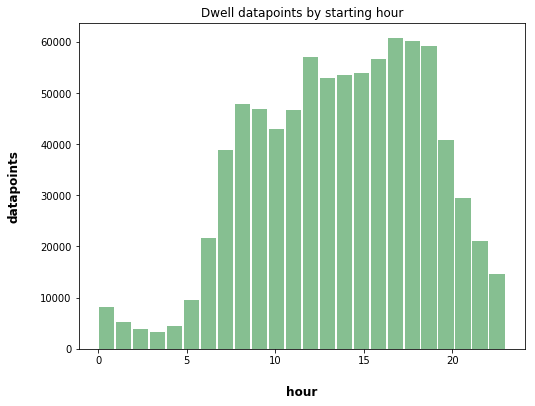

In [84]:
"""
Identify hour of each dwell start, and create histogram of points for each hour.
Does this look like a sensible dataset?
Do dwells look well distributed between working and home (awake) hours?

Notes on Working with timestamps.
The timestamps are in ISO format.  e.g. '2018-05-01T07:18:02-04:00'
The offset refers to how many hours the timezone is from Coordinated Universal Time (UTC).
"""


def get_hour(timestamp):
    return parser.parse(str(timestamp)).hour
assert(14 == get_hour('2018-05-07T14:52:22-04:00'))
# datapoint_hours = df[TIMESTAMP].apply(get_hour)

datapoint_hours = df[TIMESTAMP].apply(lambda t: t.hour)

# Make a histogram
ax = datapoint_hours.hist(bins=24, grid=False, figsize=(8,6), color='#86bf91', zorder=2, rwidth=0.9)
ax.set_title("Dwell datapoints by starting hour")
ax.set_xlabel("hour", labelpad=20, weight='bold', size=12)
ax.set_ylabel("datapoints", labelpad=20, weight='bold', size=12)

In [85]:
# Add a column for the day each dwell occurs, to allow in processing by unique days / nights
df[TIMESTAMP_DAY] = df[TIMESTAMP].apply(lambda t: t.day)

In [86]:
"""
What is the distribution of number of days of data per user?
What about nights per user?
"""


def get_user_days(df):
    """Returns a mapping of id -> unique days of datapoints"""
    return df.groupby([DEVICE_ID, TIMESTAMP_DAY])[DEVICE_ID].count().groupby(level=DEVICE_ID).count()

user_days = get_user_days(df)
print(user_days.describe())

count    83827.000000
mean         2.782588
std          1.604609
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max          5.000000
Name: device ID, dtype: float64


In [87]:
HOUR = 'hour'

NIGHTTIME_STARTHOUR = 20
NIGHTTIME_ENDHOUR = 8

def get_user_nights(df):
    """
    Returns a mapping of id -> unique nights of datapoints
    To calculate distribution of nights, first make a dataframe with just nighttime points.
    """
    user_night_df = df[[DEVICE_ID, TIMESTAMP_DAY, TIMESTAMP]]
    user_night_df[HOUR] = user_night_df[TIMESTAMP].apply(get_hour)
    # limit this dataframe to just nighttime hours
    user_night_df = user_night_df[(NIGHTTIME_STARTHOUR <= user_night_df[HOUR]) | (user_night_df[HOUR] <= NIGHTTIME_ENDHOUR)]
    user_nights = user_night_df.groupby([DEVICE_ID, TIMESTAMP_DAY])[DEVICE_ID].count().groupby(level=DEVICE_ID).count()
    return user_nights


user_nights = get_user_nights(df)
user_nights.describe()

/Users/aberke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


count    57426.000000
mean         2.351792
std          1.394592
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: device ID, dtype: float64

## Filter data by threshold number of days and/or nights of data

To do so, first create a dataframe with information about number of days and nights per user.

In [88]:
# Create dataframe with columns
# device ID, day, timestamp, user days count, user nights count
#
# And then evaluate best thresholds.

DAYS_COUNT = 'user days count'
NIGHTS_COUNT = 'user nights count'

def make_user_days_nights_df(df):
    user_days = get_user_days(df)
    user_nights = get_user_nights(df)
    user_days_nights_df = df[[DEVICE_ID, TIMESTAMP_DAY, TIMESTAMP]]
    user_days_nights_df[DAYS_COUNT] = user_days_nights_df[DEVICE_ID].map(user_days)
    user_days_nights_df[NIGHTS_COUNT] = user_days_nights_df[DEVICE_ID].map(user_nights)
    return user_days_nights_df
    
user_days_nights_df = make_user_days_nights_df(df)
user_days_nights_df.fillna(0, inplace=True)

/Users/aberke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/Users/aberke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/Users/aberke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

In [89]:
print('reminder, area population: ', area_population)

reminder, area population:  3127354


### 1 Workweet of Data

Directly below we look into how to best filter data for 1 work week of data (5 days).

The decision for how to filter is based on how many days and nights of data users have.


In [90]:
# What if we restricted data to users with at least...
# 3 unique days, 3 unique nights of data

user_3days_3nights_df = user_days_nights_df[
        (user_days_nights_df[DAYS_COUNT] >= 3) \
         & (user_days_nights_df[NIGHTS_COUNT] >= 3)
]
# How are the number of datapoints distributed across users?
print(user_3days_3nights_df[DEVICE_ID].value_counts(ascending=True).describe())

count    22559.000000
mean        22.994193
std         16.280049
min          3.000000
25%         12.000000
50%         19.000000
75%         30.000000
max        222.000000
Name: device ID, dtype: float64


In [91]:
# What if we restricted data to users with at least...
# 3 unique days, 2 unique nights of data
user_3days_2nights_df = user_days_nights_df[
        (user_days_nights_df[DAYS_COUNT] >= 3) \
         & (user_days_nights_df[NIGHTS_COUNT] >= 2)
]
# How are the number of datapoints distributed across users?
user_3days_2nights_df[DEVICE_ID].value_counts(ascending=True).describe()

count    31134.000000
mean        19.961361
std         15.342448
min          3.000000
25%          9.000000
50%         16.000000
75%         26.000000
max        222.000000
Name: device ID, dtype: float64

Decision!  Can change later...

- We restrict data to users with at least 3 unique days and 3 unique nights of data.
- This restriction means working with ~22,707 users, where the area population is ~3,127,354
- sample percentage = (users count)/(population estimate) * 100 = (22707/3127354) * 100 = ~0.726%

Note: During later data procession portions, can restrict home census tracts of interest to tracts
where there is a greater threshold number of users.

In [92]:
DAYS_THRESHOLD = 3
NIGHTS_THRESHOLD = 3

In [93]:
days_nights_1workweek_filtered_output_filepath = "{data_path}{start_day}_{end_day}/{region}_{days}days_{nights}nights.csv".format(
    data_path=FILTERED_DATA_PATH, start_day=STARTDAY, end_day=ENDDAY,
    region='county_'+'_'.join(sorted(['middlesex', 'norfolk', 'suffolk'])),
    days=DAYS_THRESHOLD, nights=NIGHTS_THRESHOLD)

print('will write filtered data to', days_nights_1workweek_filtered_output_filepath)

will write filtered data to ./data/mount/201805/filtered/20180514_20180518/county_middlesex_norfolk_suffolk_3days_3nights.csv


In [94]:
keep_users = user_3days_3nights_df[DEVICE_ID].unique()

workweek_days_nights_filtered_df = df[df[DEVICE_ID].isin(keep_users)].drop(TIMESTAMP_DAY, axis=1)
print('filtered data rows:', workweek_days_nights_filtered_df.shape[0])
print('avg users per tract:', len(keep_users)/652)

print('writing filtered output to ', days_nights_1workweek_filtered_output_filepath)
workweek_days_nights_filtered_df.to_csv(days_nights_1workweek_filtered_output_filepath, index=False)

filtered data rows: 518726
avg users per tract: 34.59969325153374
writing filtered output to  ./data/mount/201805/filtered/20180514_20180518/county_middlesex_norfolk_suffolk_3days_3nights.csv
